In [2]:
!pip install scipy

In [1]:
from inference.utils.vision_process import fetch_video

import torch
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import wasserstein_distance

In [ ]:
def plot_histogram(histo_method, histo_oracle):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    titles = ["T-Dimension Histogram (Temporal Distribution)", 
              "H-Dimension Histogram (Height Distribution)", 
              "W-Dimension Histogram (Width Distribution)"]

    x_labels = ["Time Step (T)", "Height Index (H)", "Width Index (W)"]

    bar_width = 0.4  # 设置条形宽度，使它们可以并列显示

    for i in range(3):  # 遍历 T, H, W 维度
        x = np.arange(len(histo_method[i]))  # x 轴索引

        # 绘制 method 的直方图，左侧对齐
        axes[i].bar(x - bar_width/2, histo_method[i], width=bar_width, label='Method', color='blue', alpha=0.7)

        # 绘制 oracle 的直方图，右侧对齐
        axes[i].bar(x + bar_width/2, histo_oracle[i], width=bar_width, label='Oracle', color='red', alpha=0.7)

        axes[i].set_title(titles[i])
        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel("Normalized Count")
        axes[i].legend()

    # 调整布局，使图像更紧凑
    plt.tight_layout()
    plt.show()

In [20]:
def histogram_distance(mask_method, mask_oracle):
    """
    Computes the histogram distance between the T-histograms of two masks using the Wasserstein distance.

    Parameters:
    mask_method (numpy.ndarray): The method mask of shape (T, H, W).
    mask_oracle (numpy.ndarray): The oracle mask of shape (T, H, W).

    Returns:
    float: The Wasserstein distance between the T-histograms of the two masks.
    """
    assert mask_method.shape == mask_oracle.shape, "Masks must have the same shape"
    
    # Compute histograms along the T dimension
    T_method_hist = np.sum(mask_method, axis=(1, 2)) / np.sum(mask_method)
    T_oracle_hist = np.sum(mask_oracle, axis=(1, 2)) / np.sum(mask_oracle)

    H_method_hist = np.sum(mask_method, axis=(0, 2)) / np.sum(mask_method)
    H_oracle_hist = np.sum(mask_oracle, axis=(0, 2)) / np.sum(mask_oracle)

    W_method_hist = np.sum(mask_method, axis=(0, 1)) / np.sum(mask_method)
    W_oracle_hist = np.sum(mask_oracle, axis=(0, 1)) / np.sum(mask_oracle)

    plot_histogram((T_method_hist, H_method_hist, W_method_hist), 
                (T_oracle_hist, H_oracle_hist, W_oracle_hist))

    # Compute Wasserstein distance
    distance = wasserstein_distance(np.arange(len(T_method_hist)), 
                                    np.arange(len(T_oracle_hist)), 
                                    T_method_hist, 
                                    T_oracle_hist)
    return distance/(mask_method.shape[0]-1)

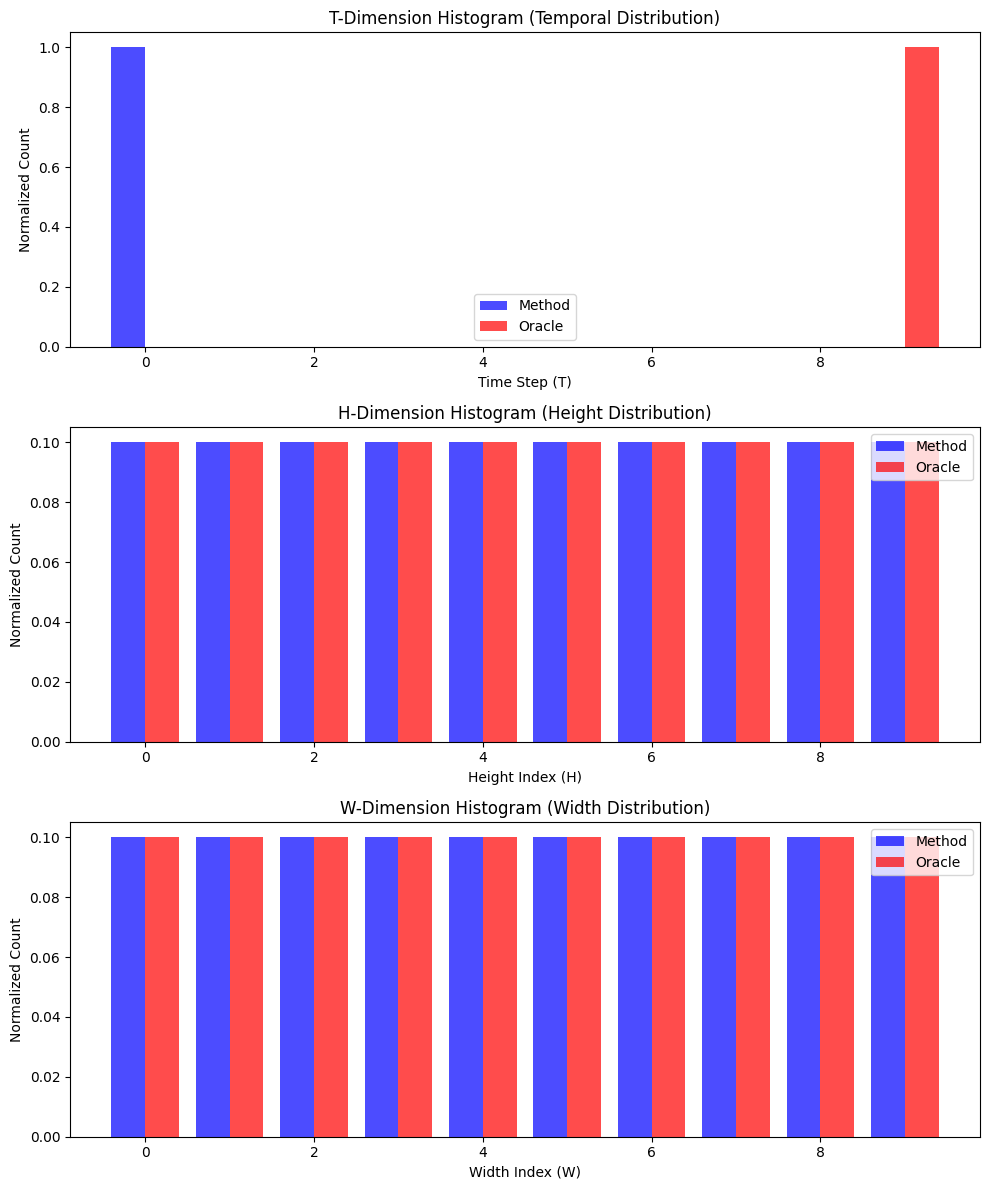

Wasserstein Distance between T-histograms: 1.0000


In [22]:
T, H, W = 10, 10, 10

mask_method_type = 'uniform'

mask_method = np.zeros((T, H, W))
if mask_method_type == 'uniform':
    for t in range(T):
        mask_method[t, :, :] = (np.random.rand(H, W) > 0.8).astype(int)  
elif mask_method_type == 'gaussian':
    mean_t = T // 2 
    std_t = T / 20
    gaussian_t = np.exp(-((np.arange(T) - mean_t) ** 2) / (2 * std_t ** 2)) 
    gaussian_t /= np.max(gaussian_t)  


    mean_h, mean_w = H // 2, W // 2
    std_h, std_w = H / 4, W / 10
    y, x = np.meshgrid(np.arange(H), np.arange(W), indexing="ij") 
    gaussian_hw = np.exp(-((y - mean_h) ** 2) / (2 * std_h ** 2) - ((x - mean_w) ** 2) / (2 * std_w ** 2))
    gaussian_hw /= np.max(gaussian_hw)  


    mask_method = np.zeros((T, H, W))
    for t in range(T):
        prob_t = gaussian_t[t] 
        mask_method[t, :, :] = (np.random.rand(H, W) < prob_t * gaussian_hw).astype(int) 

    

mask_method = np.zeros((T, H, W))
mask_method[0:1, :, :] = 1  


mask_oracle = np.zeros((T, H, W))
mask_oracle[9:10, :, :] = 1  




distance = histogram_distance(mask_method, mask_oracle)

print(f"Wasserstein Distance between T-histograms: {distance:.4f}")